## xGBoost Model for Predicting Diamond Prcies

### Load Libraries

In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
import xgboost as xgb

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

#To get month names
import calendar

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

### Load Data

In [2]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [3]:
df["date_time"] = pd.to_datetime(df["date_time"])
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,2018-09-30 22:00:00,1450


In the following chunk, I chose to make day and month quantitative variables rather than dummy variables because they may be an ordered relationship between days and months. xGboost can account for non-linear patterns so this would account for the structure of the data where 1 and 12 (Dec & Jan) and 1 and 7 (Sun and Mon) are close together 

In [4]:
df["day_of_week"] = df["date_time"].dt.dayofweek #day_name()
df["month"] = df["date_time"].dt.month #month_name()

df["hour"] = df["date_time"].dt.hour
df = df.drop(columns = ['date_time'])

df["holiday"] = df["holiday"].fillna('None')

df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,day_of_week,month,hour
0,None,288.28,0.0,0.0,40,Clouds,5545,1,10,9
1,None,289.36,0.0,0.0,75,Clouds,4516,1,10,10
2,None,289.58,0.0,0.0,90,Clouds,4767,1,10,11
3,None,290.13,0.0,0.0,90,Clouds,5026,1,10,12
4,None,291.14,0.0,0.0,75,Clouds,4918,1,10,13
...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,3543,6,9,19
48200,None,282.76,0.0,0.0,90,Clouds,2781,6,9,20
48201,None,282.73,0.0,0.0,90,Thunderstorm,2159,6,9,21
48202,None,282.09,0.0,0.0,90,Clouds,1450,6,9,22


In [5]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']

In [7]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,288.28,0.0,0.0,40,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,10,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,11,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,12,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,13,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [8]:
X_encoded.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr Day', 'holiday_Memorial Day',
       'holiday_New Years Day', 'holiday_None', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Haze', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', '

In [10]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement xGBoost Regressor

In [11]:
# Fit the model
start = time.time()            # Start Time
reg = xgb.XGBRegressor(tree_method="hist", device="cuda")
reg.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.199235200881958s


### Evaluate Prediction Performance on Test Set

In [12]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 430.00


#### Histogram of Residuals/Errors 

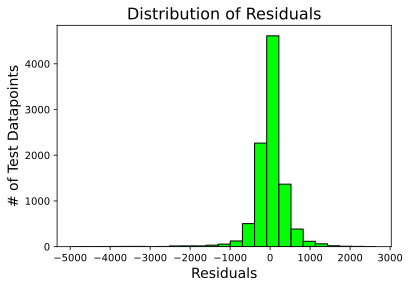

In [13]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig("residual_plot.svg", bbox_inches = 'tight')

### Scatter Plot of Predicted Vs. Actual Values

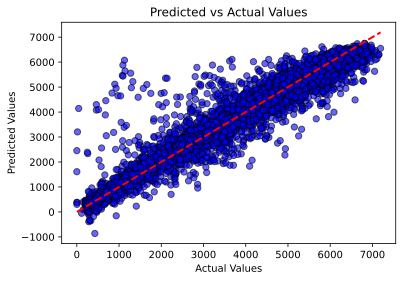

In [14]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig("pred_vs_actual.svg", bbox_inches = 'tight')

### Feature Importance Plot


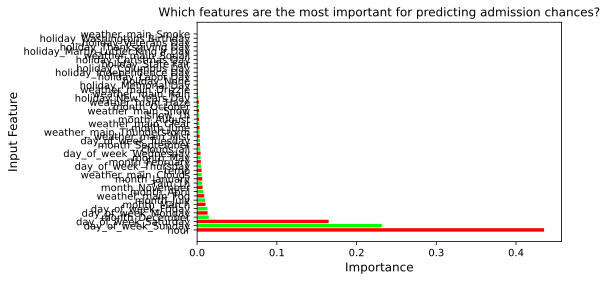

In [16]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
plt.savefig("feature_imp.svg", bbox_inches = 'tight')

### Prediction Intervals with MAPIE Regressor

In [ ]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

python(85618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/p

Training time: 3.230346918106079s


In [ ]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2570.100098,2088.87,3246.26
34004,5251,5228.589844,4654.95,5806.49
46086,2224,1918.540039,1466.69,2639.33
42579,2928,2956.070068,2301.54,3472.58
23709,910,616.309998,46.25,1200.16


### Coverage Calculation

In [ ]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.53%


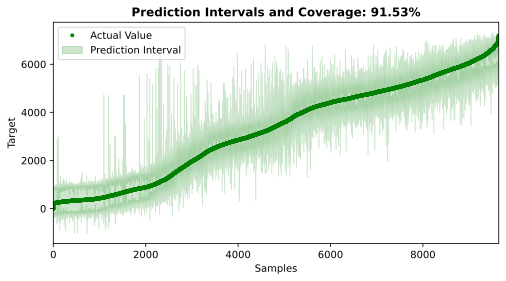

In [ ]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("coverage.svg", bbox_inches = 'tight')

### Save Model

In [ ]:
# Creating the file where we want to write the model
reg_pickle = open('reg_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()